In [1]:
library(dplyr)
library(Seurat)
library(Matrix)
library(ggplot2)
source("./sc.fun.R") # mod to skip AUCell/Harmony
source("preprocess.fun.R") # mod to skip ggsankey
load('../../data/commons.rda', verbose = T)

library(future)
plan("multisession", workers = 40)
options(future.globals.maxSize = 200*1024^3)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



Loading objects:
  cell.type.colors
  cell.types
  cell.types.nohighmito
  chr_df
  donor_sex
  fig
  flora_paper_list
  gene_type.df
  imprinted.df
  imprinted.genes
  monkey_paper_list
  monkey.genes
  monkey.markers
  nescreg.genes
  nescreg.genes.no_trg
  nescreg.genes.no_trg.early
  nescreg.list
  nescreg.list.no_trg
  nescreg.list.no_trg.early
  nescreg.markers
  nescreg.markers.no_trg
  nescreg.markers.no_trg.early
  nicola_marker_list
  origin_sex.colors
  pat.de
  pat.de.top20
  pat.list
  pat.neu.de
  pat.neu.de.top20
  pat.neu.list
  pat.neu.top20
  pat.top20
  phases
  phases.colors
  protein_coding.genes
  region.genes
  region.list
  region.markers
  samples
  samples.colors
  sex_chr.genes
  sex_chr.genes.x
  sex_chr.genes.y
  shown_2b_list
  shown_4d_list
  tf.genes
  tfs.df
  top100.sub.pat
  top100.subtype
  valid_chr


In [3]:
# data
seu <- readRDS(file = '../../raw/Inte_CellCycle_SeuScore_Seurat_annotated.rds')

In [4]:
seu <- subset(seu, anno_cluster !='High-mito')

In [5]:
seu

An object of class Seurat 
75466 features across 44311 samples within 2 assays 
Active assay: RNA (37733 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: DS
 2 dimensional reductions calculated: pca, umap

### Markers

In [4]:
##----------------------------------------------------------------
## Try different set of HVGs

## 1. 
## Set Variable features
hvg_ctrl <- subset(seu, condition %in% "Ctrl") %>%
				SplitObject(., split.by = "cell_origin") %>%
				lapply(., function(x){
                    print(x)
                    FindVariableFeatures(x, nfeatures = 2000)
                }) %>% SelectIntegrationFeatures(., nfeatures = 2000)

hvg_asd <- subset(seu, condition %in% "ASD") %>%
				SplitObject(., split.by = "cell_origin") %>%
				lapply(., function(x){
                    print(x)
                    FindVariableFeatures(x, nfeatures = 2000)
                }) %>% SelectIntegrationFeatures(., nfeatures = 2000)

hvg <- union(hvg_ctrl, hvg_asd)
saveRDS(hvg, file = "./ASD_iPSC_HVG_set1.rds")

# ## 2. 
# ## Set Variable features
# hvg <- SplitObject(seu, split.by = "cell_origin") %>%
# 				lapply(., function(x) {print(x)
#                                        FindVariableFeatures(x, nfeatures = 2000)}) %>%
# 				lapply(., function(x) VariableFeatures(x)) %>%
# 				Reduce("union", .)
# saveRDS(hvg, file = "./ASD_iPSC_HVG_set2.rds")

# ## 3. 
# ## Set Variable features
# hvg_ctrl <- subset(seu, condition %in% "Ctrl") %>%
# 				SplitObject(., split.by = "cell_origin") %>%
# 				lapply(., function(x){
#                     print(x)
#                     FindVariableFeatures(x, nfeatures = 2500)}) %>%
# 				SelectIntegrationFeatures(., nfeatures = 2000)
# hvg_asd <- subset(seu, condition %in% "ASD") %>%
# 				SplitObject(., split.by = "cell_origin") %>%
# 				lapply(., function(x){
#                     print(x)
#                     FindVariableFeatures(x, nfeatures = 2500)}) %>%
# 				SelectIntegrationFeatures(., nfeatures = 2000)
# hvg_single <- SplitObject(seu, split.by = "cell_origin") %>%
# 				lapply(., function(x){
#                     print(x)
#                     FindVariableFeatures(x, nfeatures = 1000)}) %>%
# 				lapply(., function(x) VariableFeatures(x)) %>%
# 				Reduce("union", .)
# hvg <- union(hvg_ctrl, hvg_asd) %>% union(., hvg_single)
# saveRDS(hvg, file = "./ASD_iPSC_HVG_set3.rds")

### Integrate

In [6]:
## Convert object to list
seu_list <- SplitObject(seu, split.by = "cell_origin")

In [7]:
hvgversion <- 1
hvg <- readRDS(file = paste0("./ASD_iPSC_HVG_set", hvgversion, ".rds"))

## Integration
seu.integrated_1 <- Integratelist.seurat.cellcycle(
    obj.list = seu_list,
    hvg = hvg,        
    file_name = paste0("Inte_CellCycle_SeuScore_Seurat_t2_v", hvgversion), 
    input_dir = "./", inte.dims = 1:30, cluster.dims = 1:30, 
    reference = NULL, do.cluster = FALSE)

pdf('UMAP_HGV1.pdf', width = 7, height = 7)
(DimPlot(seu.integrated_1, group.by = 'anno_cluster_fct') + NoLegend() + scale_color_manual(values=cell.type.colors)) %>% LabelClusters(id='anno_cluster_fct')
dev.off()

png 
  2

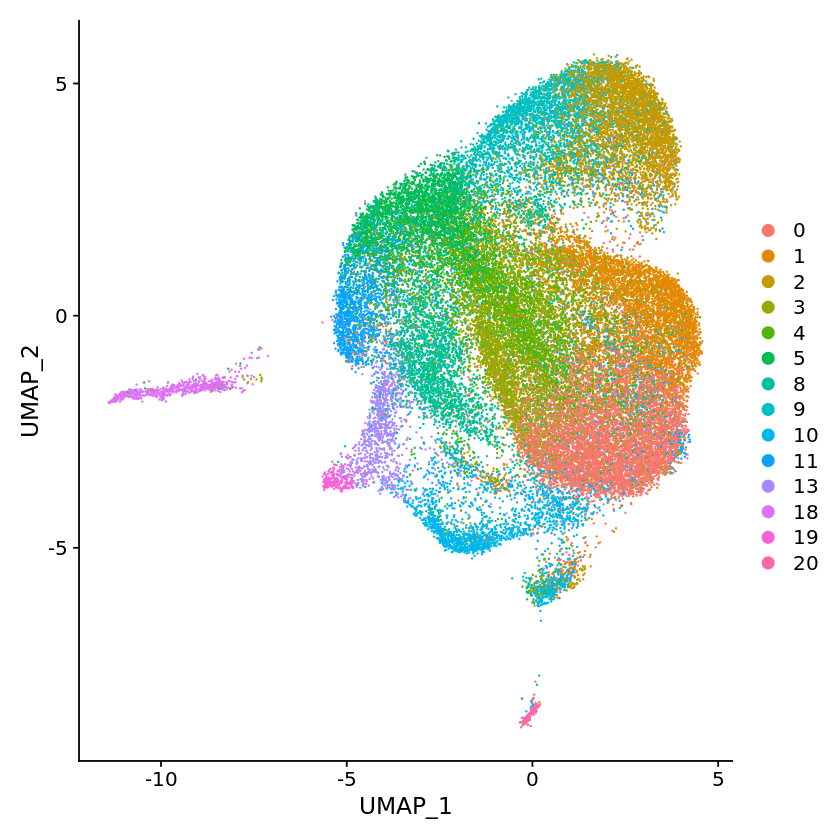

In [17]:
# seu.integrated_1 <- readRDS(file = '~/codebases/ASD_IPSC_sept/src/Jay_sub/Inte_CellCycle_SeuScore_Seurat_t2_v1.seurat.rds')

# data.table::fwrite(x = as.matrix(seu.integrated_1[['RNA']]@counts), file = 'Inte_CellCycle_SeuScore_Seurat_t2_v1.counts.tsv', nThread = 96, showProgress = T, row.names = T, sep = '\t', verbose = T)
# data.table::fwrite(x = as.matrix(seu.integrated_1[['RNA']]@data), file = 'Inte_CellCycle_SeuScore_Seurat_t2_v1.data.tsv', nThread = 96, showProgress = T, row.names = T, sep = '\t', verbose = T)
# data.table::fwrite(x = seu.integrated_1@meta.data, file = 'Inte_CellCycle_SeuScore_Seurat_t2_v1.cellmeta.tsv', nThread = 96, showProgress = T, row.names = T, sep = '\t', verbose = T)
# data.table::fwrite(x = seu.integrated_1@cell.embeddings, file = 'Inte_CellCycle_SeuScore_Seurat_t2_v1.umap.tsv', nThread = 96, showProgress = T, row.names = T, sep = '\t', verUMAPPlot = T)

In [10]:
umap<- seu.integrated_1[['umap']]@cell.embeddings
write.csv(umap, '../../data/DE_DS.NoHighMito.pp.umap.csv')


In [ ]:
# hvgversion <- 2
# hvg <- readRDS(file = paste0("./ASD_iPSC_HVG_set", hvgversion, ".rds"))

# ## Integration
# seu.integrated_2 <- Integratelist.seurat.cellcycle(
#     obj.list = seu_list,
#     hvg = hvg,        
#     file_name = paste0("Inte_CellCycle_SeuScore_Seurat_t2_v", hvgversion), 
#     input_dir = "./", inte.dims = 1:30, cluster.dims = 1:30, 
#     reference = NULL, do.cluster = FALSE)

# pdf('UMAP_HGV2.pdf', width = 7, height = 7)
# (DimPlot(seu.integrated_2, group.by = 'anno_cluster_fct') + NoLegend() + scale_color_manual(values=cell.type.colors)) %>% LabelClusters(id='anno_cluster_fct')
# dev.off()

# hvgversion <- 3
# hvg <- readRDS(file = paste0("./ASD_iPSC_HVG_set", hvgversion, ".rds"))

# ## Integration
# seu.integrated_3 <- Integratelist.seurat.cellcycle(
#     obj.list = seu_list,
#     hvg = hvg,        
#     file_name = paste0("Inte_CellCycle_SeuScore_Seurat_t2_v", hvgversion), 
#     input_dir = "./", inte.dims = 1:30, cluster.dims = 1:30, 
#     reference = NULL, do.cluster = FALSE)

# pdf('UMAP_HGV3.pdf', width = 7, height = 7)
# (DimPlot(seu.integrated_3, group.by = 'anno_cluster_fct') + NoLegend() + scale_color_manual(values=cell.type.colors)) %>% LabelClusters(id='anno_cluster_fct')
# dev.off()